# LangGraph with AgentCore Memory Checkpointer (Short term memory)

## Introduction
This notebook demonstrates how to integrate Amazon Bedrock AgentCore Memory capabilities with LangGraph using the **AgentCoreMemorySaver** checkpointer. We'll focus on **short-term memory** persistence across conversation turns - allowing an agent to maintain running context and build upon previous calculations through automatic state checkpointing.

## Tutorial Details

| Information         | Details                                                                          |
|:--------------------|:---------------------------------------------------------------------------------|
| Tutorial type       | Short Term Conversational                                                        |
| Agent usecase       | Multi-step Math Calculations                                                     |
| Agentic Framework   | Langgraph                                                                        |
| LLM model           | Anthropic Claude Haiku 4.5                                                      |
| Tutorial components | AgentCore Short-term Memory, Langgraph Checkpointer, Math Tools                |
| Example complexity  | Beginner                                                                         |

You'll learn to:
- Create a memory checkpointer with AgentCore Memory for automatic state persistence
- Use LangGraph's built-in checkpointing system with AgentCore Memory backend
- Maintain conversation context across multiple interactions
- Inspect and manage conversation state and history

### Scenario Context

In this example, we'll create a "**Math Agent**" that can perform multi-step mathematical calculations. Unlike simple one-off interactions, this agent uses AgentCore Memory's checkpointing capabilities to maintain running context, allowing it to build upon previous calculations and remember the conversation flow across multiple turns.

## Architecture
<div style="text-align:left">
    <img src="images/architecture.png" width="65%" />
</div>

## Prerequisites

- Python 3.10+
- AWS account with appropriate permissions
- AWS IAM role with appropriate permissions for AgentCore Memory
- Access to Amazon Bedrock models

### How the Integration Works

The integration between LangGraph and AgentCore Memory involves:

1. Using AgentCore Memory as a checkpointer backend for LangGraph state persistence
2. Automatic saving and loading of conversation state at each step
3. Support for multiple concurrent sessions and actors

This approach provides seamless state management without requiring manual memory operations, creating a more maintainable and scalable agent architecture.

In [1]:
# Install necessary libraries
!pip install -qr requirements.txt

In [ ]:
from IPython import get_ipython
get_ipython().kernel.do_shutdown(True)

In [2]:
# Import LangGraph and LangChain components
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langgraph.prebuilt import create_react_agent

/opt/conda/lib/python3.12/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [4]:
# Import the AgentCoreMemorySaver that we will use as a checkpointer
import os
import logging

from langgraph_checkpoint_aws import AgentCoreMemorySaver
from bedrock_agentcore.memory import MemoryClient

region = os.getenv('AWS_REGION', 'us-west-2')
logging.getLogger("math-agent").setLevel(logging.DEBUG)
# Create or get the memory resource
memory_name = "MathLanggraphAgent"
client = MemoryClient(region_name=region)
memory = client.create_memory(name=memory_name)
memory_id = memory['id']


In [6]:
print(memory_id)

MathLanggraphAgent-7b2X8M8Rr0


### AgentCore Memory Configuration

Now let's configure our AgentCore Memory checkpointer and initialize the LLM:

- `memory_id` corresponds to our AgentCore Memory resource where checkpoints will be stored
- `region` specifies the AWS region for our resources
- `MODEL_ID` defines the Bedrock model that will power our LangGraph agent

In [7]:
MODEL_ID = "global.anthropic.claude-haiku-4-5-20251001-v1:0"

# Initialize checkpointer for state persistence
checkpointer = AgentCoreMemorySaver(memory_id, region_name=region)

# Initialize LLM
llm = init_chat_model(MODEL_ID, model_provider="bedrock_converse", region_name=region)

### Mathematical Tools

Let's define the mathematical tools our agent will use. For this demonstration, we'll provide two simple operations:

In [8]:
@tool
def add(a: int, b: int):
    """Add two integers and return the result"""
    return a + b


@tool
def multiply(a: int, b: int):
    """Multiply two integers and return the result"""
    return a * b


tools = [add, multiply]

### LangGraph Agent Implementation

Now let's create our agent using LangGraph's `create_react_agent` builder with our AgentCore Memory checkpointer:

/tmp/ipykernel_274608/3477183685.py:1: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  graph = create_react_agent(


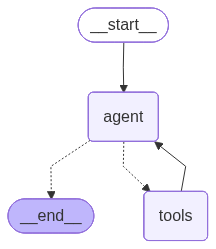

In [9]:
graph = create_react_agent(
    model=llm,
    tools=tools,
    prompt="You are a helpful assistant",
    checkpointer=checkpointer,
)

graph

## Step 4: Run the LangGraph Agent
We can now run the agent with our AgentCore Memory checkpointer integration.

### Configuration Setup
In LangGraph, config is a `RuntimeConfig` that contains attributes that are necessary at invocation time, for example user IDs or session IDs. You can read additional documentation here: [https://langchain-ai.github.io/langgraphjs/how-tos/configuration/](https://langchain-ai.github.io/langgraphjs/how-tos/configuration/)

For the AgentCore Memory checkpointer (`AgentCoreMemorySaver`), we NEED to specify:
- `thread_id`: Maps to AgentCore session_id (unique conversation thread)
- `actor_id`: Maps to AgentCore actor_id (user, agent, or any other identifier)

In [10]:
config = {
    "configurable": {
        "thread_id": "session-1", # REQUIRED: This maps to Bedrock AgentCore session_id under the hood
        "actor_id": "react-agent-1", # REQUIRED: This maps to Bedrock AgentCore actor_id under the hood
    }
}

inputs = {"messages": [{"role": "user", "content": "What is 1337 times 515321? Then add 412 and return the value to me."}]}

#### Congratulations! Your Agent is ready!!

### Let's test the Agent

Let's run our first calculation to see the agent in action:

In [12]:
for chunk in graph.stream(inputs, stream_mode="updates", config=config):
    print(chunk)

{'agent': {'messages': [AIMessage(content=[{'type': 'text', 'text': "I'll calculate 1337 times 515321, then add 412 to the result."}, {'type': 'tool_use', 'name': 'multiply', 'input': {'a': 1337, 'b': 515321}, 'id': 'tooluse_PnzIG9OF7Oh5v9I17G8rdR'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'cb92b9a0-735b-4016-9527-5d830b7cab20', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 17 Feb 2026 18:23:15 GMT', 'content-type': 'application/json', 'content-length': '501', 'connection': 'keep-alive', 'x-amzn-requestid': 'cb92b9a0-735b-4016-9527-5d830b7cab20'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': [1723]}, 'model_name': 'global.anthropic.claude-haiku-4-5-20251001-v1:0'}, id='run--afb0f729-ad6e-4190-b045-26064c597a5d-0', tool_calls=[{'name': 'multiply', 'args': {'a': 1337, 'b': 515321}, 'id': 'tooluse_PnzIG9OF7Oh5v9I17G8rdR', 'type': 'tool_call'}], usage_metadata={'input_tokens': 665, 'output_tokens': 92, 'total_tokens': 75

### Inspecting Agent State

Let's examine the current conversation state stored in AgentCore Memory. The checkpointer automatically saves and retrieves state for our actor and session:

In [13]:
for message in graph.get_state(config).values.get("messages"):
    print(f"{message.type}: {message.text()}")
    print("=========================================")

human: What is 1337 times 515321? Then add 412 and return the value to me.
ai: I'll calculate 1337 times 515321, then add 412 to the result.
tool: 688984177
ai: Now I'll add 412 to that result:
tool: 688984589
ai: The answer is **688,984,589**.

To break it down:
- 1337 × 515,321 = 688,984,177
- 688,984,177 + 412 = **688,984,589**


### Viewing Checkpoint History

Let's explore the checkpoint history to see how the agent's state evolved during execution.  Checkpoints are listed in reverse chronological order (most recent appear first).

In [14]:
for checkpoint in graph.get_state_history(config):
    print(
        f"(Checkpoint ID: {checkpoint.config['configurable']['checkpoint_id']}) # of messages in state: {len(checkpoint.values.get('messages'))}"
    )

Adding placeholder ToolMessage for orphaned tool_call 'add' (id: tooluse_fBlcSdeqgUpu3KBel5HeOw) during checkpoint load
Adding placeholder ToolMessage for orphaned tool_call 'multiply' (id: tooluse_PnzIG9OF7Oh5v9I17G8rdR) during checkpoint load


(Checkpoint ID: 1f10c2db-cd48-68d9-8005-1f1b2397cb80) # of messages in state: 6
(Checkpoint ID: 1f10c2db-ad7e-69b9-8004-8fbd9385f8ed) # of messages in state: 5
(Checkpoint ID: 1f10c2db-ad71-6b23-8003-20284a8b8c0a) # of messages in state: 5
(Checkpoint ID: 1f10c2db-a11d-6fb6-8002-9289b68df732) # of messages in state: 3
(Checkpoint ID: 1f10c2db-a10f-6d6d-8001-29782b219b51) # of messages in state: 3
(Checkpoint ID: 1f10c2db-9062-6952-8000-b34c7f57e203) # of messages in state: 1
(Checkpoint ID: 1f10c2db-9057-6c3d-bfff-5bd67fde8734) # of messages in state: 0


### Testing Memory Persistence

Now let's test the power of our checkpointer by continuing the conversation. The agent should remember our previous calculations:

In [15]:
inputs = {"messages": [{"role": "user", "content": "What were the first calculations I asked you to do?"}]}

for chunk in graph.stream(inputs, stream_mode="updates", config=config):
    print(chunk)

{'agent': {'messages': [AIMessage(content='The first calculations you asked me to do were:\n\n1. **Multiply** 1337 times 515321\n2. **Add** 412 to the result\n\nThese were part of your single request to calculate 1337 × 515321, then add 412 and return the final value.', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '59c5c814-b0d9-4395-af2f-2c44f96ea17a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 17 Feb 2026 18:23:37 GMT', 'content-type': 'application/json', 'content-length': '542', 'connection': 'keep-alive', 'x-amzn-requestid': '59c5c814-b0d9-4395-af2f-2c44f96ea17a'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [1169]}, 'model_name': 'global.anthropic.claude-haiku-4-5-20251001-v1:0'}, id='run--95c19741-1c06-42ab-806d-8e4f3ed0c71a-0', usage_metadata={'input_tokens': 942, 'output_tokens': 70, 'total_tokens': 1012, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}})]}}


### Starting a New Session

Let's demonstrate session isolation by creating a new conversation thread. The agent won't remember the previous calculations in this new session:

In [16]:
config = {
    "configurable": {
        "thread_id": "session-2", # New session ID
        "actor_id": "react-agent-1", # Same Actor ID
    }
}

inputs = {"messages": [{"role": "user", "content": "What values did I ask you to multiply and add?"}]}
for chunk in graph.stream(inputs, stream_mode="updates", config=config):
    print(chunk)

{'agent': {'messages': [AIMessage(content="I don't have any record of you asking me to multiply and add specific values in our conversation. This is the beginning of our chat, so you haven't made any such requests yet.\n\nWould you like me to multiply and add some numbers for you? If so, please provide the values you'd like me to work with!", additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '5724b63f-5f52-4f78-a039-8fb95f81c755', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 17 Feb 2026 18:23:44 GMT', 'content-type': 'application/json', 'content-length': '614', 'connection': 'keep-alive', 'x-amzn-requestid': '5724b63f-5f52-4f78-a039-8fb95f81c755'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [1641]}, 'model_name': 'global.anthropic.claude-haiku-4-5-20251001-v1:0'}, id='run--87a23d52-c227-416a-9a42-200ce3185292-0', usage_metadata={'input_tokens': 653, 'output_tokens': 70, 'total_tokens': 723, 'input_token_details': {'cache_cre

## Summary

In this notebook, we've demonstrated:

1. How to create an AgentCore Memory resource for checkpointing
2. Building a LangGraph agent with automatic state persistence
3. Implementing mathematical tools for multi-step calculations
4. Using the AgentCoreMemorySaver as a checkpointer backend
5. Testing memory persistence and session isolation

This integration showcases the power of combining LangGraph's structured workflows with AgentCore Memory's robust checkpointing capabilities to create stateful, persistent AI agents that can maintain context across multiple interactions.

The approach we've demonstrated can be extended to more complex use cases, including multi-agent systems, long-running workflows, and specialized state management based on conversation context.

### Clean up
Let's delete the memory to clean up the resources used in this notebook.

In [ ]:
client.delete_memory_and_wait(memory_id = memory_id, max_wait = 300, poll_interval =10)